### **Metritis Risk Classification Using Dynamic and Static Features**

This notebook contains a machine learning workflow for classifying metritis risk in cows based on both dynamic and static features derived from time-series data. The classification task leverages statistical representations of time-series data combined with static variables to build predictive models for detecting different stages of metritis, such as healthy, mild metritis, and acute metritis.

#### **Library Installation and Imports**
   - The necessary libraries such as `numpy`, `scipy`, `pandas`, `scikit-learn`, `matplotlib`, and `xgboost` are installed and imported.
   - Additional utilities from Git (`git.Repo`) and Python’s standard libraries like `os` and `getpass` are used for repository management and authentication.

In [ ]:
# !pip install numpy scipy scikit-learn==1.2.2 xgboost tabpfn matplotlib
!pip install numpy scipy scikit-learn xgboost matplotlib

In [ ]:
import os
import getpass
from git import Repo
import shutil
import pandas as pd

#### **GitHub Repository Cloning**
   - The notebook clones a GitHub repository (`metritis-risk-classification`) containing the dataset and possibly other resources for this project.
   - Authentication is handled either via a GitHub Personal Access Token (PAT) or through username/password credentials.

In [ ]:
# ------------------- START: Authentication  -------------------
# Option A: Personal Access Token (Recommended)
os.environ['GITHUB_TOKEN'] = None # Replace with your actual PAT
# Option B: Username and Password (Less Secure - if you use it comment the above line)
# github_username = input("Enter your GitHub username: ")
# github_password = getpass.getpass("Enter your GitHub password: ")
# ------------------- END: Authentication  -------------------

# --- Change this if needed
repo_url = "https://github.com/JoseFRuiz/metritis-risk-classification.git"
repo_path = "/content/metritis-risk-classification"


if 'GITHUB_TOKEN' in os.environ:
    # Using PAT in the clone url
    repo_url_with_token = repo_url.replace("https://", f"https://{os.environ['GITHUB_TOKEN']}@")
    if not os.path.exists(repo_path):
        Repo.clone_from(repo_url_with_token, repo_path)
else:
    # Using username and password in the clone url
    repo_url_with_credentials = f"https://{github_username}:{github_password}@{repo_url[8:]}"
    if not os.path.exists(repo_path):
      Repo.clone_from(repo_url_with_credentials, repo_path)

os.chdir(repo_path)

#### **Data Loading and Exploration**
   - A dataset (`dataset_20240614.csv`) is loaded from the cloned repository.
   - Basic exploration is performed to understand the structure of the data, which includes columns like `ID`, `FarmC`, `DIM`, `BCSCollar`, `∆BCS`, `THI`, and various health indicators (`Metritis`, `AcuteMetritis`, `NewClassifier`, etc.).
   - Missing values are dropped for simplicity.

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.utils._tags import _safe_tags  # Import for patching

# Load data
data = pd.read_csv(os.path.join('data','dataset_20240614.csv'))

# Preprocess data
data = data.dropna()  # Dropping rows with missing values for simplicity
data

,ID,FarmC,DIM,Metritis,AcuteMetritis,NewClassifier,LactNo,ColCalvInt,BCSCollar,∆BCS,...,StillBirth,Twins,Dystocia,RP,VLS,THI,EstFeeding,EstRum,EstIdle,EstActive
0,4996,A,-14,0,0,Healthy,7,16,3.25,-0.25,...,0,0,0,0,0,78.976676,213,288,733,197
1,4996,A,-13,0,0,Healthy,7,16,3.25,-0.25,...,0,0,0,0,0,79.833294,141,386,712,186
2,4996,A,-12,0,0,Healthy,7,16,3.25,-0.25,...,0,0,0,0,0,81.317806,178,463,616,167
3,4996,A,-11,0,0,Healthy,7,16,3.25,-0.25,...,0,0,0,0,0,81.339995,171,506,540,203
4,4996,A,-10,0,0,Healthy,7,16,3.25,-0.25,...,0,0,0,0,0,81.957688,179,483,502,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,86723,B,-3,1,1,AcuteMetritis,1,35,3.75,-0.75,...,0,0,0,1,2,91.950577,101,438,530,176
8009,86723,B,-2,1,1,AcuteMetritis,1,35,3.75,-0.75,...,0,0,0,1,2,91.924553,128,443,445,361
8010,86723,B,-1,1,1,AcuteMetritis,1,35,3.75,-0.75,...,0,0,0,1,2,92.837267,92,430,518,296
8011,86723,B,0,1,1,AcuteMetritis,1,35,3.75,-0.75,...,0,0,0,1,2,94.901822,86,51,693,486


#### **Feature Engineering**
   - **Dynamic Variables:** Features that vary over time (e.g., `DIM`, `THI`, `EstFeeding`) are treated as time-series data.
   - **Static Variables:** Features that remain constant for a given cow (e.g., `LactNo`, `ColCalvInt`, `RP`, `VLS`).
   - Time-series data for each cow is processed:
     - Dynamic variables are normalized using `StandardScaler`.
     - Sequences are padded to ensure uniform length across all cows.
   - **Statistical Representation:**
     - Summary statistics (mean, standard deviation, min, max, kurtosis, and skewness) are computed for the dynamic variables to capture their distributional properties.
   - Combined Feature Matrix:
     - The statistical representations of the dynamic variables are concatenated with static variables to form the final feature matrix.
   - Labels (`NewClassifier`) are encoded into numerical values for compatibility with machine learning models (`Healthy: 0`, `MildMetritis: 1`, `AcuteMetritis: 2`).

In [ ]:
# Define features and target
static_vars = ['LactNo', 'ColCalvInt', 'Male', 'StillBirth', 'Twins', 'Dystocia', 'RP', 'VLS']
dynamic_vars = ['DIM', 'BCSCollar', '∆BCS', 'THI', 'EstFeeding', 'EstRum', 'EstIdle', 'EstActive']
target_var = 'NewClassifier'

# Extract unique cow IDs
cow_ids = data['ID'].unique()

# Create dictionaries to hold static and dynamic data
static_data = {}
dynamic_data = {}

# Iterate over each cow ID to separate static and dynamic data
for cow_id in cow_ids:
    cow_data = data[data['ID'] == cow_id]
    static_data[cow_id] = cow_data[static_vars].iloc[0].values
    dynamic_data[cow_id] = cow_data[dynamic_vars].values

# Normalize dynamic variables
scaler = StandardScaler()
for cow_id in cow_ids:
    dynamic_data[cow_id][:, 1:] = scaler.fit_transform(dynamic_data[cow_id][:, 1:])  # Normalize except first dynamic var

# Determine the maximum sequence length
max_len = max([len(dynamic_data[cow_id]) for cow_id in cow_ids])

# Pad sequences
for cow_id in cow_ids:
    dynamic_data[cow_id] = np.pad(dynamic_data[cow_id], ((0, max_len - len(dynamic_data[cow_id])), (0, 0)), 'constant')

# Compute statistics for dynamic data
def compute_statistics(dynamic_data):
    statistics = {}
    for cow_id, data in dynamic_data.items():
        statistics[cow_id] = np.hstack([
            np.mean(data, axis=0),
            np.std(data, axis=0),
            np.min(data, axis=0),
            np.max(data, axis=0),
            pd.DataFrame(data).kurtosis(axis=0).values,
            pd.DataFrame(data).skew(axis=0).values
        ])
    return statistics

dynamic_statistics = compute_statistics(dynamic_data)

# Combine features (excluding FarmC)
combined_features = np.array([np.concatenate((dynamic_statistics[cow_id], static_data[cow_id])) for cow_id in cow_ids if cow_id in dynamic_statistics])
labels = np.array([data[data['ID'] == cow_id][target_var].values[0] for cow_id in cow_ids if cow_id in dynamic_statistics])

# Manually encode labels to ensure correct mapping
label_mapping = {'Healthy': 0, 'MildMetritis': 1, 'AcuteMetritis': 2}
labels = np.array([label_mapping[label] for label in labels])

#### **Model Building**
   - A variety of machine learning classifiers are initialized, including:
     - Random Forest, Logistic Regression, Decision Trees, SVM, KNN, XGBoost, Gradient Boosting, AdaBoost, and Extra Trees.
   - These classifiers are used to explore different algorithms' performance on the classification task.

In [ ]:
# Define the patch to add __sklearn_tags__
def __sklearn_tags__(self):
    tags = _safe_tags(self, key="estimator_type")
    tags.append("classifier")  # Add "classifier" tag
    return tags

# Apply the patch to XGBClassifier
XGBClassifier.__sklearn_tags__ = __sklearn_tags__

# Define a function to directly fit XGBClassifier
def fit_xgb_classifier(clf, X, y):
    """Fits an XGBClassifier without RandomizedSearchCV."""
    if isinstance(clf, XGBClassifier):
        clf.fit(X, y)
    return clf

# Apply the patch to XGBClassifier
XGBClassifier.__sklearn_tags__ = __sklearn_tags__

# Define a function to directly fit XGBClassifier
def fit_xgb_classifier(clf, X, y):
    """Fits an XGBClassifier without RandomizedSearchCV."""
    if isinstance(clf, XGBClassifier):
        clf.fit(X, y)
    return clf

# Initialize base classifiers with the wrapper
base_classifiers = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(random_state=42)),  # Use regular XGBClassifier
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('et', ExtraTreesClassifier(random_state=42))
]

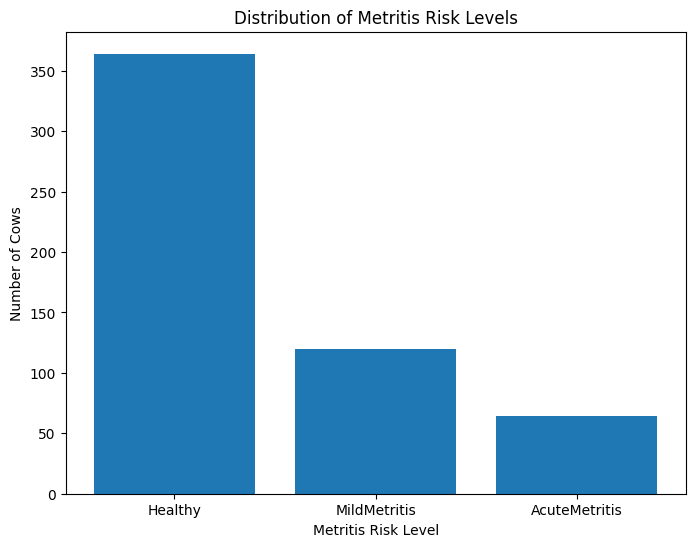

In [ ]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=range(len(label_mapping) + 1), align='left', rwidth=0.8)  # Use label_mapping for bins
plt.xticks(range(len(label_mapping)), label_mapping.keys())  # Set x-axis ticks and labels
plt.xlabel("Metritis Risk Level")
plt.ylabel("Number of Cows")
plt.title("Distribution of Metritis Risk Levels")
plt.show()

Model training and hyperparameter tuning (via `RandomizedSearchCV`).

In [ ]:
from scipy.stats import randint, uniform  # Import randint and uniform

# Select which farm to use for training
train_farm = 'A'  # Change to 'B' to use Farm B for training

# Option to use the same data for testing
use_same_data = False # Set to True if you want to use the same data for both training and testing

farm_mapping = data.drop_duplicates(subset='ID').set_index('ID')['FarmC'].to_dict()

if use_same_data:
    if train_farm == 'A':
        train_mask = np.array([farm_mapping[cow_id] == 'A' for cow_id in cow_ids if cow_id in dynamic_statistics])
        test_mask = train_mask
    else:
        train_mask = np.array([farm_mapping[cow_id] == 'B' for cow_id in cow_ids if cow_id in dynamic_statistics])
        test_mask = train_mask
    train_test_label = f"train_{train_farm}_test_same"
else:
    if train_farm == 'A':
        train_mask = np.array([farm_mapping[cow_id] == 'A' for cow_id in cow_ids if cow_id in dynamic_statistics])
        test_mask = np.array([farm_mapping[cow_id] == 'B' for cow_id in cow_ids if cow_id in dynamic_statistics])
        train_test_label = "train_A_test_B"
    else:
        train_mask = np.array([farm_mapping[cow_id] == 'B' for cow_id in cow_ids if cow_id in dynamic_statistics])
        test_mask = np.array([farm_mapping[cow_id] == 'A' for cow_id in cow_ids if cow_id in dynamic_statistics])
        train_test_label = "train_B_test_A"

X_train = combined_features[train_mask]
y_train = labels[train_mask]

X_test = combined_features[test_mask]
y_test = labels[test_mask]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define hyperparameter distributions for the classifiers (TabPFN does not need hyperparameter tuning)
param_distributions = {
    'rf': {
        'n_estimators': randint(100, 200),
        'max_depth': [None, 10, 20],
        'min_samples_split': randint(2, 5),
        'min_samples_leaf': randint(1, 2),
    },
    'svm': {
        'C': [1e-2, 1e-1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
    },
    'knn': {
        'n_neighbors': randint(3, 7),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'xgb': {
        'n_estimators': randint(100, 200),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 7)
    },
    'gb': {
        'n_estimators': randint(100, 200),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 7)
    },
    'ada': {
        'n_estimators': randint(50, 1000),
        'learning_rate': uniform(0.01, 0.99)
    },
    'et': {
        'n_estimators': randint(100, 200),
        'max_depth': [None, 10, 20],
        'min_samples_split': randint(2, 5),
        'min_samples_leaf': randint(1, 2)
    }
}

# Perform hyperparameter tuning with RandomizedSearchCV
print("Starting hyperparameter tuning...")
best_classifiers = {}
for name, clf in base_classifiers:
    print(f"Tuning hyperparameters for {name}...")
    if name in param_distributions and name != 'xgb':  # Exclude 'xgb'
        random_search = RandomizedSearchCV(clf, param_distributions[name], n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
        random_search.fit(X_train, y_train)
        best_classifiers[name] = random_search.best_estimator_
        print(f"Best parameters for {name}: {random_search.best_params_}")
    else:
        best_classifiers[name] = fit_xgb_classifier(clf, X_train, y_train) if name == 'xgb' else clf.fit(X_train, y_train) # Fit XGBClassifier separately or others
    print(f"Finished tuning {name}")


Starting hyperparameter tuning...
Tuning hyperparameters for rf...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for rf: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
Finished tuning rf
Tuning hyperparameters for lr...
Finished tuning lr
Tuning hyperparameters for dt...
Finished tuning dt
Tuning hyperparameters for svm...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for svm: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Finished tuning svm
Tuning hyperparameters for knn...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for knn: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
Finished tuning knn
Tuning hyperparameters for xgb...
Finished tuning xgb
Tuning hyperparameters for gb...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for gb: {'learning_rate': 0.020718200015149048, 'max_depth': 6, 'n_estimators': 129}
Fi

In [ ]:
import os

# ... (your existing code) ...

# Check if the 'results' directory exists, and create it if it doesn't
if not os.path.exists('results'):
    os.makedirs('results')  # Use os.makedirs to create nested directories if needed

# ... (rest of your code, including the to_csv call) ...

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import os
from google.colab import drive
import shutil

# Collect predictions from individual classifiers
print("Collecting predictions...")
predictions = {'ID': cow_ids[test_mask], 'Actual': y_test}
for name, clf in best_classifiers.items():
    predictions[name] = clf.predict(X_test)
print("Finished collecting predictions")

# Create DataFrame with the collected predictions
print("Creating DataFrame...")
predictions_df = pd.DataFrame(predictions)

# Save the DataFrames to CSV files
print(f"Saving DataFrames to CSV files with label {train_test_label}...")
predictions_df.to_csv(os.path.join('results',
                      f'class_predictions_{train_test_label}.csv'), index=False)

print(predictions_df.head())

# Compute performance measures with bootstrapping
print("Computing performance measures with bootstrapping...")
performance_measures = []
n_bootstraps = 1000
rng = np.random.RandomState(42)

for name in predictions_df.columns[2:]:  # Skip 'ID' and 'Actual' columns
    bootstrapped_accuracies = []
    bootstrapped_precisions = []
    bootstrapped_recalls = []
    bootstrapped_f1s = []
    bootstrapped_aucs = []
    bootstrapped_sensitivities = []
    bootstrapped_specificities = []
    bootstrapped_ppvs = []
    bootstrapped_npvs = []
    pred_labels = predictions_df[name]

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(pred_labels), len(pred_labels))
        if len(np.unique(predictions_df['Actual'].iloc[indices])) < 2:
            # Skip this sample because it has less than two classes
            continue
        # Convert relevant columns to dense numpy arrays
        actual_values = predictions_df['Actual'].iloc[indices].to_numpy(dtype=int)  # Ensure integer type
        predicted_values = pred_labels.iloc[indices]

        # Compute metrics
        score_acc = accuracy_score(actual_values, predicted_values)
        score_prec = precision_score(actual_values, predicted_values, average='weighted', zero_division=1)
        score_rec = recall_score(actual_values, predicted_values, average='weighted', zero_division=1)
        score_f1 = f1_score(actual_values, predicted_values, average='weighted', zero_division=1)

        # Compute AUC only if probability estimates are available
        if hasattr(best_classifiers[name], 'predict_proba'):
          # Adjust indexing based on the type of X_test
          if isinstance(X_test, pd.DataFrame):
              proba_values = best_classifiers[name].predict_proba(X_test.iloc[indices])
          else:  # Assume X_test is a NumPy array
              proba_values = best_classifiers[name].predict_proba(X_test[indices])

          # Compute multiclass AUC with 'ovr' (One-vs-Rest)
          score_auc = roc_auc_score(actual_values, proba_values, multi_class='ovr')
        else:
          score_auc = np.nan  # Skip AUC calculation if predict_proba is not available

        # Compute the confusion matrix for multiclass classification
        cm = confusion_matrix(actual_values, predicted_values)

        # Compute metrics for each class
        sensitivity_list = []
        specificity_list = []
        ppv_list = []
        npv_list = []

        for i in range(cm.shape[0]):  # Iterate over each class
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - (tp + fn + fp)

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0

            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)
            ppv_list.append(ppv)
            npv_list.append(npv)

        # Average the metrics across all classes (macro-average)
        score_sensitivity = np.mean(sensitivity_list)
        score_specificity = np.mean(specificity_list)
        score_ppv = np.mean(ppv_list)
        score_npv = np.mean(npv_list)

        # Append metrics to bootstrapped lists
        bootstrapped_accuracies.append(score_acc)
        bootstrapped_precisions.append(score_prec)
        bootstrapped_recalls.append(score_rec)
        bootstrapped_f1s.append(score_f1)
        bootstrapped_aucs.append(score_auc)
        bootstrapped_sensitivities.append(score_sensitivity)
        bootstrapped_specificities.append(score_specificity)
        bootstrapped_ppvs.append(score_ppv)
        bootstrapped_npvs.append(score_npv)

    # Compute 95% confidence intervals
    def calculate_ci(values):
        return (np.percentile(values, 2.5), np.percentile(values, 97.5))

    performance_measures.append({
        'Classifier': name,
        'Accuracy': np.mean(bootstrapped_accuracies),
        'Accuracy CI': calculate_ci(bootstrapped_accuracies),
        'Precision': np.mean(bootstrapped_precisions),
        'Precision CI': calculate_ci(bootstrapped_precisions),
        'Recall': np.mean(bootstrapped_recalls),
        'Recall CI': calculate_ci(bootstrapped_recalls),
        'F1-Score': np.mean(bootstrapped_f1s),
        'F1-Score CI': calculate_ci(bootstrapped_f1s),
        'AUC': np.mean(bootstrapped_aucs),
        'AUC CI': calculate_ci(bootstrapped_aucs),
        'Sensitivity': np.mean(bootstrapped_sensitivities),
        'Sensitivity CI': calculate_ci(bootstrapped_sensitivities),
        'Specificity': np.mean(bootstrapped_specificities),
        'Specificity CI': calculate_ci(bootstrapped_specificities),
        'PPV': np.mean(bootstrapped_ppvs),
        'PPV CI': calculate_ci(bootstrapped_ppvs),
        'NPV': np.mean(bootstrapped_npvs),
        'NPV CI': calculate_ci(bootstrapped_npvs)
    })

# Create a DataFrame for the performance measures
performance_df = pd.DataFrame(performance_measures)

# Save the performance measures DataFrame to a CSV file
print(f"Saving performance measures DataFrame to CSV file with label {train_test_label}...")
performance_df.to_csv(os.path.join('results',
                      f'class_performance_measures_{train_test_label}.csv'), index=False)

print(performance_df)
print("Finished computing and saving performance measures.")

# Mount Google Drive
drive.mount('/content/drive')

# Define the destination folder in Google Drive
google_drive_folder = '/content/drive/My Drive/Colab Results/'

# Ensure the folder exists (create it if necessary)
os.makedirs(google_drive_folder, exist_ok=True)

# Define the source files and move them to Google Drive
source_predictions = os.path.join('results', f'class_predictions_{train_test_label}.csv')
source_performance = os.path.join('results', f'class_performance_measures_{train_test_label}.csv')

# Copy the files to Google Drive
shutil.copy(source_predictions, google_drive_folder)
shutil.copy(source_performance, google_drive_folder)

print(f"Files have been saved to your Google Drive folder: {google_drive_folder}")




Finished collecting predictions
Creating DataFrame...
Saving DataFrames to CSV files with label train_B_test_A...
     ID  Actual  rf  lr  dt  svm  knn  xgb  gb  ada  et
0  4996       0   0   0   0    0    0    0   0    0   0
1  5105       1   0   1   0    0    0    0   0    0   0
2  6158       0   0   0   0    0    0    0   0    0   0
3  6341       0   0   0   0    0    0    0   0    0   0
4  6445       0   0   0   0    0    0    1   0    0   0
Computing performance measures with bootstrapping...
Saving performance measures DataFrame to CSV file with label train_B_test_A...
  Classifier  Accuracy                                Accuracy CI  Precision  \
0         rf  0.657417                  (0.6, 0.7119491525423728)   0.613211   
1         lr  0.626997   (0.5728813559322034, 0.6847457627118644)   0.589585   
2         dt  0.507969  (0.45084745762711864, 0.5627966101694915)   0.523649   
3        svm  0.664468   (0.6101694915254238, 0.7186440677966102)   0.696643   
4        knn  0.64

In [ ]:
if not os.path.exists('results'):
    os.mkdir('results')

Performance evaluation

# Explainability

In [ ]:
# import pickle
#
# # Load saved variables
# save_path = 'variables.pkl'
# with open(save_path, 'rb') as f:
#     loaded_variables = pickle.load(f)
# best_classifiers = loaded_variables['best_classifiers']
# X_test = loaded_variables['X_test']
# y_test = loaded_variables['y_test']
# dynamic_vars = loaded_variables['dynamic_vars']
# static_vars = loaded_variables['static_vars']

This section provides a detailed exploration of our metritis risk classification models' decision-making process through a comprehensive explainability analysis. We employ several techniques to understand how different features influence model predictions.

First, we utilize **permutation importance** to quantify each feature's contribution. Permutation importance measures the decrease in model performance (specifically, the F1-score in our case) when a feature's values are randomly shuffled. This provides a global understanding of feature importance. Mathematically, for a feature *j*, we calculate the permutation importance as:
content_copy
download
Use code with caution.
Markdown

Importance(j) = Mean( score(original model) - score(model with feature j permuted) )

Where `score` is the F1-score and we average the score differences over several random permutations.

Second, we employ **SHAP (SHapley Additive exPlanations) values**, a model-agnostic method that provides both global and local explanations. SHAP values quantify each feature's contribution to a specific prediction relative to the average prediction. In our specific case we are using the `KernelExplainer` as it provides a robust way to calculate SHAP values independently of the model. Due to the multi-class nature of our classification problem, we use `KernelExplainer` with a wrapper around `predict_proba` for the models that output probabilities, otherwise, we use the predict method. For a data point *i* and feature *j*, the SHAP value (φᵢ(j)) represents its contribution and can be mathematically approximated as:

φᵢ(j) ≈ Σ ( [f(zᵢ + j) - f(zᵢ - j) ] )

where f is the model's prediction function, zᵢ is the data point *i*, zᵢ+j represents a data point with feature j perturbed and zᵢ-j represents a data point where the feature j is not perturbed.  The sum is over all possible combinations of feature perturbations. The SHAP value for a data point and feature represents the difference of its prediction compared to the average of all predictions.

Thirdly, we generate **partial dependence plots (PDPs)** to illustrate how each feature impacts the model's prediction across its range for each class. PDPs visualize the marginal effect of a feature on the predicted outcome, holding all other features constant. Mathematically, the partial dependence of feature *j* at value *x* is given by:

PDPⱼ(x) = Eₓ[f(X)|Xⱼ = x]

where Eₓ denotes the expectation, f(X) is the model's prediction function, and *Xⱼ* is the feature *j*. We calculate this over a grid of values for *x* to visualize the impact of this feature on prediction.

Finally, for the models that have it, we extract coefficient information, providing directionality on the model decision. We also compute and store the feature importance information separately for static and dynamic features, allowing us to gain insights into each type of feature. Through these explainability tools, we aim to provide a thorough and reliable understanding of the factors driving the model's predictions, which can then be used to improve the models and inform decision-making.

Estimating feature importance...
Calculating feature importance for rf...
Calculating feature importance for lr...
Calculating feature importance for dt...
Calculating feature importance for svm...
Calculating feature importance for knn...
Calculating feature importance for xgb...
Calculating feature importance for gb...
Calculating feature importance for ada...
Calculating feature importance for et...
Calculating SHAP values...
  Calculating SHAP values for rf...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for lr...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for dt...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for svm...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for knn...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for xgb...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for gb...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for ada...


  0%|          | 0/295 [00:00<?, ?it/s]

  Calculating SHAP values for et...


  0%|          | 0/295 [00:00<?, ?it/s]

Generating Partial Dependence Plots...
  Generating PDP for rf...
  Generating PDP for lr...
  Generating PDP for dt...
  Generating PDP for svm...
  Generating PDP for knn...
  Generating PDP for xgb...
    PDP generation failed for xgb. Error: 'super' object has no attribute '__sklearn_tags__'
  Generating PDP for gb...
  Generating PDP for ada...
  Generating PDP for et...
Separating static and dynamic importances...
  rf: Total features = 56, Static = 8, Dynamic = 48
  lr: Total features = 56, Static = 8, Dynamic = 48
  dt: Total features = 56, Static = 8, Dynamic = 48
  svm: Total features = 56, Static = 8, Dynamic = 48
  knn: Total features = 56, Static = 8, Dynamic = 48
  xgb: Total features = 56, Static = 8, Dynamic = 48
  gb: Total features = 56, Static = 8, Dynamic = 48
  ada: Total features = 56, Static = 8, Dynamic = 48
  et: Total features = 56, Static = 8, Dynamic = 48
                  rf        lr        dt       svm       knn       xgb  \
LactNo      0.002432  0.079798

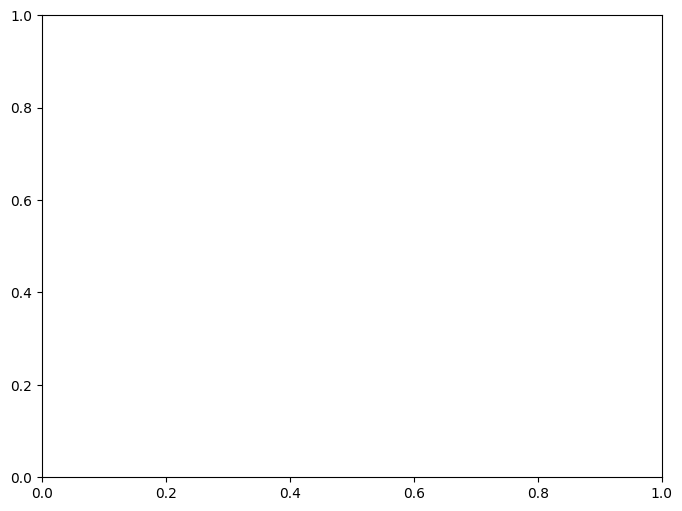

In [ ]:
import pandas as pd
import pickle
import numpy as np
import os
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import f1_score
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

expanded_dynamic_vars = []
for var in dynamic_vars:
    for stat in ['mean', 'std', 'min', 'max', 'kurtosis', 'skewness']:
        expanded_dynamic_vars.append(f'{var}_{stat}')

all_feature_names = expanded_dynamic_vars + static_vars

# ---------------------------------------------------
# 1. Feature Importance (current implementation + fixes)
# ---------------------------------------------------
print("Estimating feature importance...")
feature_importances = {}
feature_selection = {}  # Store feature selection
for name, clf in best_classifiers.items():
    print(f"Calculating feature importance for {name}...")
    if hasattr(clf, 'feature_importances_'):
        feature_importances[name] = clf.feature_importances_
        feature_selection[name] = all_feature_names
    elif hasattr(clf, 'coef_'):
        feature_importances[name] = clf.coef_[0]  # Keep sign information
        feature_selection[name] = all_feature_names
    else:
        # Use permutation importance as fallback
        def calculate_permutation_importance(clf, X, y, feature_names, sample_size=500):
            if len(X) > sample_size:
              idx = np.random.choice(len(X), sample_size, replace=False)
              X_sample, y_sample = X[idx], y[idx]
            else:
              X_sample, y_sample = X, y

            result = permutation_importance(clf, X_sample, y_sample, n_repeats=10, random_state=42, scoring='f1_weighted') # Using f1
            return pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})

        perm_importance_df = calculate_permutation_importance(clf, X_test, y_test, all_feature_names, sample_size=500)
        feature_importances[name] = perm_importance_df.set_index('Feature')['Importance'].values
        feature_selection[name] = all_feature_names
        perm_importance_df.to_csv(os.path.join('results', f'permutation_importance_{name}.csv'), index=False)

# ---------------------------------------------------
# 2. SHAP (SHapley Additive exPlanations)
# ---------------------------------------------------
print("Calculating SHAP values...")
shap_values_dict = {}
background_size = 50  # You can change this parameter
for name, clf in best_classifiers.items():
    try:
        print(f"  Calculating SHAP values for {name}...")
        if hasattr(clf, 'predict_proba'): # Models with predict_proba
            # Sample or use K-Means to reduce background data
            background_data = shap.sample(X_test, background_size)  # Use random sampling
             # Create a wrapper to return only the probability of the positive class for the background data
            def predict_proba_wrapper(background_data):
              return clf.predict_proba(background_data)[:, 1]  # returns the probability of the second class
            explainer = shap.KernelExplainer(predict_proba_wrapper, background_data)
            shap_values = explainer.shap_values(X_test)
        elif hasattr(clf, 'predict'): # Models with predict only
            # Sample or use K-Means to reduce background data
            background_data = shap.sample(X_test, background_size)
            explainer = shap.KernelExplainer(clf.predict, background_data)
            shap_values = explainer.shap_values(X_test)
        else: # Fallback if none of the conditions match
            print(f"   {name} doesn't have a  predict_proba or predict method, skipping SHAP calculation")
            shap_values = None # if no SHAP values

        # Save SHAP values
        if shap_values is not None:
            with open(os.path.join('results', f'shap_values_{name}.pkl'), 'wb') as f:
               pickle.dump(shap_values, f)

            # Generate and save summary plot
            plt.figure()
            if isinstance(shap_values, list):  # Handle multiclass output
                for i, class_shap_values in enumerate(shap_values):
                    shap.summary_plot(class_shap_values, X_test, feature_names = all_feature_names, plot_type="bar",show=False)
                    plt.savefig(os.path.join('results', f'shap_summary_plot_{name}_class{i}.png'))
            else: # Handle other situations
                 shap.summary_plot(shap_values, X_test, feature_names = all_feature_names, plot_type="bar",show=False)
                 plt.savefig(os.path.join('results', f'shap_summary_plot_{name}.png'))
            plt.close() # Close figure

    except Exception as e:
        print(f"    SHAP calculation failed for {name}. Error: {e}")

# ---------------------------------------------------
# 3. Partial Dependence Plots (PDP)
# ---------------------------------------------------
print("Generating Partial Dependence Plots...")
for name, clf in best_classifiers.items():
    try:
        print(f"  Generating PDP for {name}...")
        if hasattr(clf, 'predict_proba'):
            for feature_idx, feature_name in enumerate(all_feature_names):
                for target_class in range(len(np.unique(y_test))): #iterate over the classes
                    fig, ax = plt.subplots(figsize=(8, 6))
                    PartialDependenceDisplay.from_estimator(clf, X_test, [feature_idx], target = target_class, feature_names = all_feature_names, ax = ax) # Plot PDP for class
                    plt.title(f"PDP for {feature_name} with {name} (Class {target_class})")
                    plt.savefig(os.path.join('results', f'pdp_{name}_{feature_name}_class{target_class}.png'))
                    plt.close()  # Close figure to avoid overlapping
        else:
            print(f"    Skipping PDP for {name} (does not support predict_proba)")
    except Exception as e:
        print(f"    PDP generation failed for {name}. Error: {e}")

# ---------------------------------------------------
# 4. Separate Static and Dynamic Importances
# ---------------------------------------------------
print("Separating static and dynamic importances...")
static_importance_df = pd.DataFrame()
dynamic_importance_df = pd.DataFrame()
num_stats_per_dynamic_var = 6
static_len = len(static_vars)
dynamic_len = len(dynamic_vars) * num_stats_per_dynamic_var

for name, importances in feature_importances.items():
    total_length = len(importances)
    print(f"  {name}: Total features = {total_length}, Static = {static_len}, Dynamic = {dynamic_len}")

    # Check if the classifier supports feature selection
    if  name in feature_selection and len(feature_selection[name]) == total_length:
        static_importance_df[name] = pd.Series(importances[:static_len], index=static_vars)
        dynamic_importance_df[name] = pd.Series(importances[static_len:], index=expanded_dynamic_vars)
    else:
        print(f"    Warning: Mismatch in feature lengths for {name}. Handling without selection...")
        static_importance_df[name] = pd.Series(importances[:static_len], index=static_vars)
        if total_length > static_len:
            dynamic_importance_df[name] = pd.Series(importances[static_len:], index=expanded_dynamic_vars[:total_length-static_len])
        else:
            dynamic_importance_df[name] = pd.Series([np.nan] * dynamic_len, index=expanded_dynamic_vars)

# Save the DataFrames to CSV files
static_importance_df.to_csv(os.path.join('results',
                            f'static_variable_importance_{train_test_label}.csv'), index_label='Static_Variable')
dynamic_importance_df.to_csv(os.path.join('results',
                             f'dynamic_variable_importance_{train_test_label}.csv'), index_label='Dynamic_Variable')

print(static_importance_df.head())
print(dynamic_importance_df.head())

print("Finished explainability analysis.")

from google.colab import drive
import shutil  # Import shutil for file operations

# Mount Google Drive
drive.mount('/content/drive')

# Define the destination folder in Google Drive
google_drive_folder = '/content/drive/My Drive/Colab Results/'

# Ensure the folder exists (create it if necessary)
os.makedirs(google_drive_folder, exist_ok=True)

# Define the source files and move them to Google Drive
source_predictions = os.path.join('results',
                            f'static_variable_importance_{train_test_label}.csv')
source_performance = os.path.join('results',
                             f'dynamic_variable_importance_{train_test_label}.csv')

# Copy the files to Google Drive
shutil.copy(source_predictions, google_drive_folder)
shutil.copy(source_performance, google_drive_folder)

print(f"Files have been saved to your Google Drive folder: {google_drive_folder}")

In [ ]:
!zip -r /content/metritis-risk-classification.zip /content/metritis-risk-classification
